Import serval lines of code from FinRL girhub repository

In [86]:
@article{liu2021finrl,
    author  = {Liu, Xiao-Yang and Yang, Hongyang and Gao, Jiechao and Wang, Christina Dan},
    title   = {{FinRL}: Deep reinforcement learning framework to automate trading in quantitative finance},
    journal = {ACM International Conference on AI in Finance (ICAIF)},
    year    = {2021}
}


SyntaxError: invalid syntax. Perhaps you forgot a comma? (401829808.py, line 2)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [2]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])


Define Train data Start & End date.

In [3]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [4]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2020-12-31'
TRADE_START_DATE = '2020-12-01'
TRADE_END_DATE = '2022-01-01'

Create Dataframe

In [5]:
assignment3 = YahooDownloader(start_date = TRAIN_START_DATE,
                              end_date = TRADE_END_DATE,
                              ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [8]:
assignment3.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.479000,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.817795,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.300182,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777546,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.523598,7325600,CAT,0


FeatureEnginner Process

In [9]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_vix=True,
    use_turbulence=True,
    user_defined_feature=False
)

assignment3 = fe.preprocess_data(assignment3)


Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3020, 8)
Successfully added vix
Successfully added turbulence index


In [10]:
list_ticker = assignment3["tic"].unique().tolist()
list_date = list(pd.date_range(assignment3['date'].min(), assignment3['date'].max()).astype(str))
combination = list(itertools.product(list_date, list_ticker))

processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(assignment3, on=["date", "tic"], how="left")
processed_full = processed_full[processed_full['date'].isin(assignment3['date'])]
processed_full = processed_full.sort_values(['date', 'tic'])

processed_full = processed_full.fillna(method='ffill').fillna(method='bfill')

processed_full['log_return'] = np.log(processed_full.groupby('tic')['close'].pct_change() + 1)

processed_full = processed_full.dropna(subset=['log_return'])

processed_full = processed_full.fillna(0)


In [11]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,log_return
0,2010-01-05,AAPL,7.664286,7.699643,7.616071,6.490202,601904800.0,1.0,0.000251,6.500443,6.468758,100.0,66.666667,100.0,6.484601,6.484601,19.35,0.0,0.001728
1,2010-01-05,AMGN,57.330002,57.689999,56.270000,41.455547,7882800.0,1.0,-0.008127,42.148966,41.124376,0.0,-66.666667,100.0,41.636671,41.636671,19.35,0.0,-0.008700
2,2010-01-05,AXP,40.830002,41.230000,40.369999,33.226959,10641200.0,1.0,-0.001643,33.367124,33.160018,0.0,66.666667,100.0,33.263571,33.263571,19.35,0.0,-0.002201
3,2010-01-05,BA,56.250000,58.279999,56.000000,45.211338,8867800.0,1.0,0.032168,46.522130,42.466754,100.0,66.666667,100.0,44.494442,44.494442,19.35,0.0,0.032227
4,2010-01-05,CAT,58.549999,59.439999,58.230000,41.008091,5697200.0,1.0,0.010870,41.451021,40.080667,100.0,66.666667,100.0,40.765844,40.765844,19.35,0.0,0.011885
5,2010-01-05,CRM,18.612499,18.750000,18.200001,18.625000,7942400.0,1.0,-0.001795,18.778137,18.551863,0.0,-66.666667,100.0,18.665000,18.665000,19.35,0.0,-0.004286
6,2010-01-05,CSCO,24.600000,24.730000,24.379999,16.935862,45124500.0,1.0,-0.001701,17.080948,16.866569,0.0,66.666667,100.0,16.973759,16.973759,19.35,0.0,-0.004465
7,2010-01-05,CVX,79.220001,79.620003,78.720001,45.801289,10593700.0,1.0,0.007228,46.095800,45.184630,100.0,66.666667,100.0,45.640215,45.640215,19.35,0.0,0.007058
8,2010-01-05,DIS,32.070000,32.160000,31.700001,27.864239,10307700.0,1.0,-0.001563,27.997627,27.800534,0.0,-66.666667,100.0,27.899080,27.899080,19.35,0.0,-0.002498
9,2010-01-05,GS,173.000000,176.259995,172.570007,140.091843,11659400.0,1.0,0.054603,142.316807,135.433132,100.0,66.666667,100.0,138.874969,138.874969,19.35,0.0,0.017525


In [12]:
train = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE, TRADE_END_DATE)
train_length = len(train)
trade_length = len(trade)
print(train_length)
print(trade_length)


80243
7917


In [13]:
train.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,log_return
0,2010-01-05,AAPL,7.664286,7.699643,7.616071,6.490202,601904800.0,1.0,0.000251,6.500443,6.468758,100.0,66.666667,100.0,6.484601,6.484601,19.35,0.0,0.001728
0,2010-01-05,AMGN,57.330002,57.689999,56.270000,41.455547,7882800.0,1.0,-0.008127,42.148966,41.124376,0.0,-66.666667,100.0,41.636671,41.636671,19.35,0.0,-0.008700
0,2010-01-05,AXP,40.830002,41.230000,40.369999,33.226959,10641200.0,1.0,-0.001643,33.367124,33.160018,0.0,66.666667,100.0,33.263571,33.263571,19.35,0.0,-0.002201
0,2010-01-05,BA,56.250000,58.279999,56.000000,45.211338,8867800.0,1.0,0.032168,46.522130,42.466754,100.0,66.666667,100.0,44.494442,44.494442,19.35,0.0,0.032227
0,2010-01-05,CAT,58.549999,59.439999,58.230000,41.008091,5697200.0,1.0,0.010870,41.451021,40.080667,100.0,66.666667,100.0,40.765844,40.765844,19.35,0.0,0.011885


In [14]:
trade.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,log_return
272,2021-12-30,UNH,507.929993,509.230011,503.649994,492.338379,1309800.0,3.0,13.355037,505.291940,435.990613,68.152060,119.926924,47.180930,458.188483,443.064066,17.33,7.367085,-0.002277
272,2021-12-30,V,217.970001,219.149994,217.149994,214.530701,3812800.0,3.0,2.679075,220.776943,195.584139,52.338432,104.407506,16.865397,203.921174,210.604015,17.33,7.367085,-0.001376
272,2021-12-30,VZ,52.380001,52.570000,52.080002,46.148716,15615500.0,3.0,0.246256,47.629668,43.659115,50.091013,62.425766,2.129279,45.511613,45.974720,17.33,7.367085,-0.002103
272,2021-12-30,WBA,52.360001,52.919998,51.939999,46.356331,3653600.0,3.0,0.939515,47.138938,40.880142,60.253125,157.294054,41.478245,43.143461,43.006367,17.33,7.367085,-0.004989
272,2021-12-30,WMT,143.259995,143.699997,142.479996,139.352310,4983000.0,3.0,-0.151117,142.370919,130.975699,51.028371,51.422236,4.010760,137.322507,139.284155,17.33,7.367085,0.003218


In [15]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [16]:
FEATURE_COLUMNS = ['open', 'high', 'low', 'close', 'volume', 'day', 
                   'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 
                   'dx_30', 'close_30_sma', 'close_60_sma', 'vix', 'turbulence', 'log_return']
TARGET_COLUMN = 'log_return'

features = processed_full[FEATURE_COLUMNS]
target = processed_full[TARGET_COLUMN]
test_features = processed_full[FEATURE_COLUMNS]
test_target = processed_full[TARGET_COLUMN]


In [17]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = feature_scaler.fit_transform(features)  # Multiple columns

target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target.values.reshape(-1, 1)).reshape(-1,)

scaled_test_features = feature_scaler.transform(test_features)  # Use feature_scaler
scaled_test_target = target_scaler.transform(test_target.values.reshape(-1, 1)).reshape(-1,)  # Use target_scaler


In [18]:
def create_sequences(input_data, target_data, time_steps):
    X, y = [], []
    for i in range(len(input_data) - time_steps):
        X.append(input_data[i:(i + time_steps)])
        y.append(target_data[i + time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 30
X_train, y_train = create_sequences(scaled_features, scaled_target, TIME_STEPS)
X_test, y_test = create_sequences(scaled_test_features, test_target.values, TIME_STEPS)


In [19]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Define the input shape (sequence_length, number_of_features)
input_shape = (X_train.shape[1], X_train.shape[2])

# Basic RNN model
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(50, return_sequences=True, input_shape=input_shape),
        SimpleRNN(50),
        Dense(25),
        Dense(1)
    ])
    return model

# LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(25),
        Dense(1)
    ])
    return model

# GRU model
def build_gru_model(input_shape):
    model = Sequential([
        GRU(50, return_sequences=True, input_shape=input_shape),
        GRU(50),
        Dense(25),
        Dense(1)
    ])
    return model

def build_bidirectional_rnn_model(input_shape):
    model = Sequential([
        Bidirectional(SimpleRNN(50, return_sequences=True), input_shape=input_shape),
        Bidirectional(SimpleRNN(50)),
        Dense(25),
        Dense(1)
    ])
    return model

def build_stacked_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(50, return_sequences=True, input_shape=input_shape),
        SimpleRNN(50, return_sequences=True),
        SimpleRNN(50),
        Dense(25),
        Dense(1)
    ])
    return model


In [21]:
def compile_model(model):
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

rnn_model = compile_model(build_rnn_model(input_shape))
lstm_model = compile_model(build_lstm_model(input_shape))
gru_model = compile_model(build_gru_model(input_shape))
bbrnn_model = compile_model(build_bidirectional_rnn_model(input_shape))
bsrnn_model = compile_model(build_stacked_rnn_model(input_shape))


In [22]:
import time

start_time = time.time()
history_rnn = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, shuffle=False)
end_time = time.time()
rnn_training_time = end_time - start_time
print("RNN Training Time: {:.2f} seconds".format(rnn_training_time))


Epoch 1/50

1751/1751 [==============================] - 14s 6ms/step - loss: 0.0027 - val_loss: 8.3453e-04
Epoch 2/50
1751/1751 [==============================] - 10s 6ms/step - loss: 0.0012 - val_loss: 7.7246e-04
Epoch 3/50
1751/1751 [==============================] - 10s 6ms/step - loss: 0.0011 - val_loss: 9.3387e-04
Epoch 4/50
1751/1751 [==============================] - 10s 6ms/step - loss: 9.9556e-04 - val_loss: 0.0010
Epoch 5/50
1751/1751 [==============================] - 10s 6ms/step - loss: 9.3128e-04 - val_loss: 7.5132e-04
Epoch 6/50
1751/1751 [==============================] - 10s 6ms/step - loss: 9.0492e-04 - val_loss: 7.2221e-04
Epoch 7/50
1751/1751 [==============================] - 10s 6ms/step - loss: 8.7990e-04 - val_loss: 7.4589e-04
Epoch 8/50
1751/1751 [==============================] - 10s 6ms/step - loss: 8.5035e-04 - val_loss: 7.5287e-04
Epoch 9/50
1751/1751 [==============================] - 10s 6ms/step - loss: 8.4046e-04 - val_loss: 7.1821e-04
Epoch 10/50
1751

In [23]:
start_time = time.time()
history_lstm = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, shuffle=False)
end_time = time.time()
lstm_training_time = end_time - start_time
print("LSTM Training Time: {:.2f} seconds".format(lstm_training_time))


Epoch 1/50
1751/1751 [==============================] - 25s 13ms/step - loss: 0.0014 - val_loss: 7.7481e-04
Epoch 2/50
1751/1751 [==============================] - 21s 12ms/step - loss: 8.0786e-04 - val_loss: 9.0359e-04
Epoch 3/50
1751/1751 [==============================] - 21s 12ms/step - loss: 7.8304e-04 - val_loss: 8.4188e-04
Epoch 4/50
1751/1751 [==============================] - 21s 12ms/step - loss: 7.6644e-04 - val_loss: 7.6189e-04
Epoch 5/50
1751/1751 [==============================] - 21s 12ms/step - loss: 7.5508e-04 - val_loss: 7.0980e-04
Epoch 6/50
1751/1751 [==============================] - 21s 12ms/step - loss: 7.4131e-04 - val_loss: 6.9029e-04
Epoch 7/50
1751/1751 [==============================] - 21s 12ms/step - loss: 7.3070e-04 - val_loss: 6.8630e-04
Epoch 8/50
1751/1751 [==============================] - 22s 12ms/step - loss: 7.2190e-04 - val_loss: 6.8425e-04
Epoch 9/50
1751/1751 [==============================] - 21s 12ms/step - loss: 7.1533e-04 - val_loss: 6.8003e

In [24]:
start_time = time.time()
history_gru = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, shuffle=False)
end_time = time.time()
gru_training_time = end_time - start_time
print("GRU Training Time: {:.2f} seconds".format(gru_training_time))


Epoch 1/50
1751/1751 [==============================] - 20s 10ms/step - loss: 0.0012 - val_loss: 7.5579e-04
Epoch 2/50
1751/1751 [==============================] - 18s 10ms/step - loss: 8.0143e-04 - val_loss: 7.1063e-04
Epoch 3/50
1751/1751 [==============================] - 18s 10ms/step - loss: 7.7194e-04 - val_loss: 8.2922e-04
Epoch 4/50
1751/1751 [==============================] - 17s 10ms/step - loss: 7.4633e-04 - val_loss: 8.3527e-04
Epoch 5/50
1751/1751 [==============================] - 18s 10ms/step - loss: 7.3406e-04 - val_loss: 7.5217e-04
Epoch 6/50
1751/1751 [==============================] - 18s 10ms/step - loss: 7.2637e-04 - val_loss: 6.8820e-04
Epoch 7/50
1751/1751 [==============================] - 18s 10ms/step - loss: 7.1642e-04 - val_loss: 6.6426e-04
Epoch 8/50
1751/1751 [==============================] - 17s 10ms/step - loss: 7.0883e-04 - val_loss: 6.5868e-04
Epoch 9/50
1751/1751 [==============================] - 17s 10ms/step - loss: 7.0186e-04 - val_loss: 6.5579e

In [25]:
start_time = time.time()
history_bidirectional_rnn = bbrnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, shuffle=False)
end_time = time.time()
bidirectional_rnn_training_time = end_time - start_time
print("Bidirectional RNN Training Time: {:.2f} seconds".format(bidirectional_rnn_training_time))


Epoch 1/50
1751/1751 [==============================] - 17s 9ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 2/50
1751/1751 [==============================] - 15s 9ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/50
1751/1751 [==============================] - 15s 9ms/step - loss: 0.0011 - val_loss: 7.2728e-04
Epoch 4/50
1751/1751 [==============================] - 15s 9ms/step - loss: 0.0010 - val_loss: 7.1404e-04
Epoch 5/50
1751/1751 [==============================] - 15s 9ms/step - loss: 9.6690e-04 - val_loss: 7.4921e-04
Epoch 6/50
1751/1751 [==============================] - 15s 9ms/step - loss: 9.4038e-04 - val_loss: 0.0011
Epoch 7/50
1751/1751 [==============================] - 15s 9ms/step - loss: 9.0633e-04 - val_loss: 8.2500e-04
Epoch 8/50
1751/1751 [==============================] - 15s 9ms/step - loss: 8.7383e-04 - val_loss: 7.7536e-04
Epoch 9/50
1751/1751 [==============================] - 15s 9ms/step - loss: 8.4621e-04 - val_loss: 7.6224e-04
Epoch 10/50
1751/1751 [======

In [26]:
start_time = time.time()
history_stacked_rnn = bsrnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, shuffle=False)
end_time = time.time()
stacked_rnn_training_time = end_time - start_time
print("Stacked RNN Training Time: {:.2f} seconds".format(stacked_rnn_training_time))


Epoch 1/50
1751/1751 [==============================] - 13s 7ms/step - loss: 0.0035 - val_loss: 9.1013e-04
Epoch 2/50
1751/1751 [==============================] - 11s 6ms/step - loss: 0.0012 - val_loss: 8.2248e-04
Epoch 3/50
1751/1751 [==============================] - 11s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/50
1751/1751 [==============================] - 11s 6ms/step - loss: 0.0010 - val_loss: 9.2072e-04
Epoch 5/50
1751/1751 [==============================] - 11s 6ms/step - loss: 9.5331e-04 - val_loss: 8.1999e-04
Epoch 6/50
1751/1751 [==============================] - 11s 6ms/step - loss: 9.2598e-04 - val_loss: 8.0733e-04
Epoch 7/50
1751/1751 [==============================] - 11s 6ms/step - loss: 9.1179e-04 - val_loss: 7.8721e-04
Epoch 8/50
1751/1751 [==============================] - 11s 6ms/step - loss: 8.7995e-04 - val_loss: 7.8889e-04
Epoch 9/50
1751/1751 [==============================] - 11s 6ms/step - loss: 8.4892e-04 - val_loss: 7.7850e-04
Epoch 10/50
1751/1751

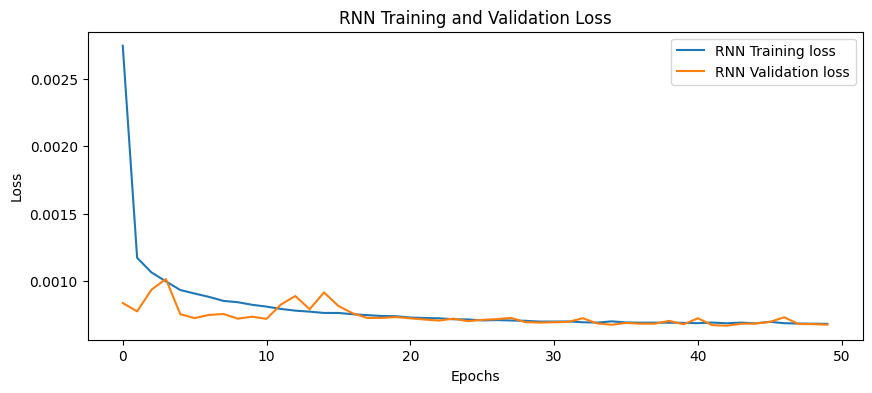

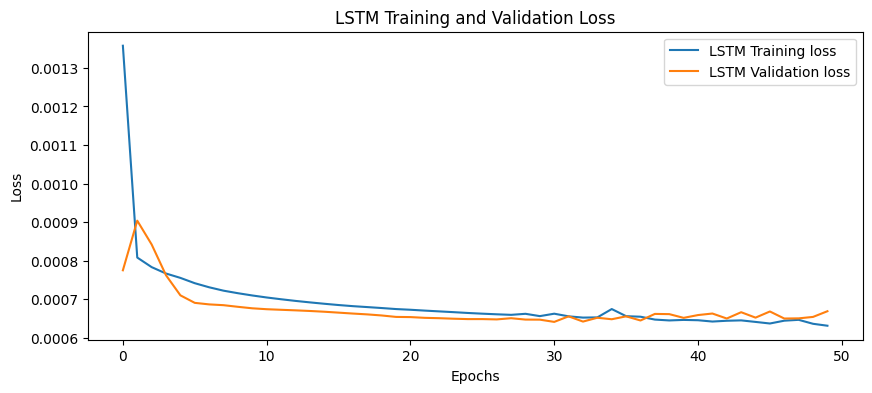

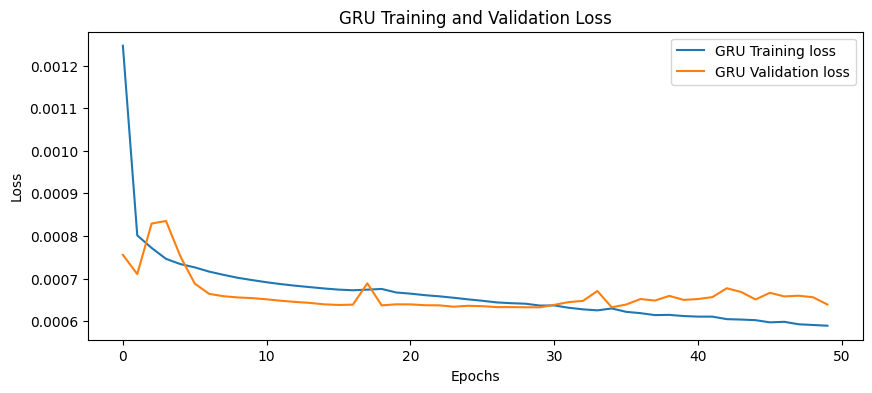

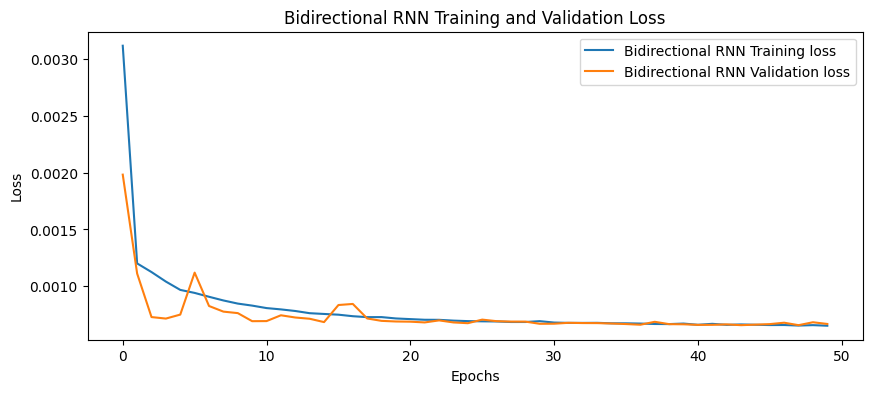

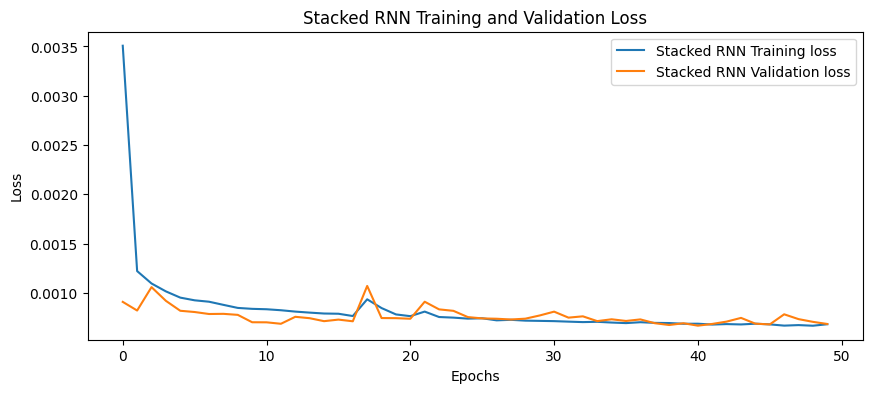

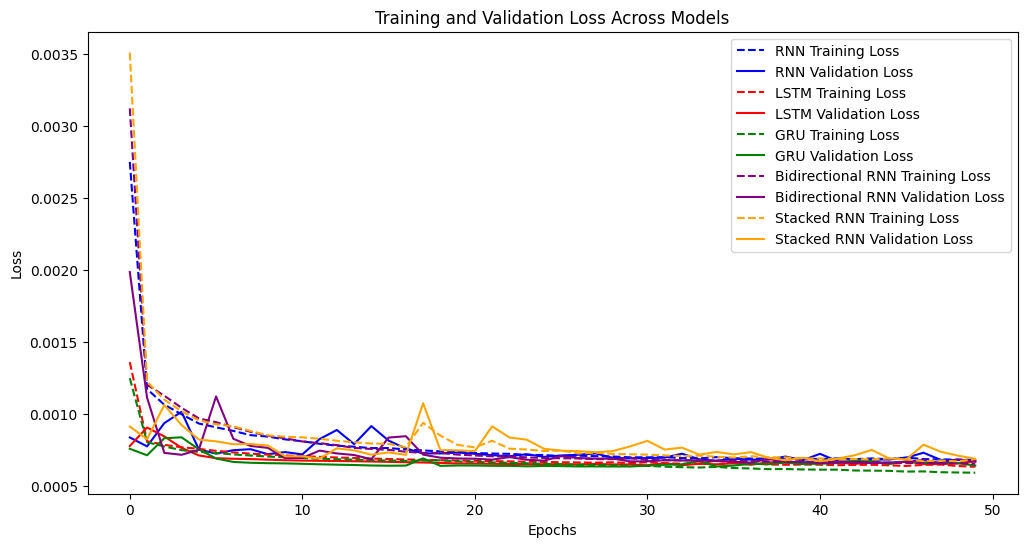

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(history_rnn.history['loss'], label='RNN Training loss')
plt.plot(history_rnn.history['val_loss'], label='RNN Validation loss')
plt.title('RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history_lstm.history['loss'], label='LSTM Training loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history_gru.history['loss'], label='GRU Training loss')
plt.plot(history_gru.history['val_loss'], label='GRU Validation loss')
plt.title('GRU Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history_bidirectional_rnn.history['loss'], label='Bidirectional RNN Training loss')
plt.plot(history_bidirectional_rnn.history['val_loss'], label='Bidirectional RNN Validation loss')
plt.title('Bidirectional RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history_stacked_rnn.history['loss'], label='Stacked RNN Training loss')
plt.plot(history_stacked_rnn.history['val_loss'], label='Stacked RNN Validation loss')
plt.title('Stacked RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_rnn.history['loss'], label='RNN Training Loss', color='blue', linestyle='dashed')
plt.plot(history_rnn.history['val_loss'], label='RNN Validation Loss', color='blue')
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss', color='red', linestyle='dashed')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss', color='red')
plt.plot(history_gru.history['loss'], label='GRU Training Loss', color='green', linestyle='dashed')
plt.plot(history_gru.history['val_loss'], label='GRU Validation Loss', color='green')
plt.plot(history_bidirectional_rnn.history['loss'], label='Bidirectional RNN Training Loss', color='purple', linestyle='dashed')
plt.plot(history_bidirectional_rnn.history['val_loss'], label='Bidirectional RNN Validation Loss', color='purple')
plt.plot(history_stacked_rnn.history['loss'], label='Stacked RNN Training Loss', color='orange', linestyle='dashed')
plt.plot(history_stacked_rnn.history['val_loss'], label='Stacked RNN Validation Loss', color='orange')
plt.title('Training and Validation Loss Across Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predictions
predictions_rnn = rnn_model.predict(X_test)
predictions_lstm = lstm_model.predict(X_test)
predictions_gru = gru_model.predict(X_test)
predictions_bidirectional_rnn = bbrnn_model.predict(X_test)
predictions_stacked_rnn = bsrnn_model.predict(X_test)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mse, mae, rmse

metrics_rnn = calculate_metrics(y_test, predictions_rnn)
metrics_lstm = calculate_metrics(y_test, predictions_lstm)
metrics_gru = calculate_metrics(y_test, predictions_gru)
metrics_bidirectional_rnn = calculate_metrics(y_test, predictions_bidirectional_rnn)
metrics_stacked_rnn = calculate_metrics(y_test, predictions_stacked_rnn)

# Function to print metrics
def print_metrics(model_name, metrics):
    print(f"{model_name} - MSE: {metrics[0]:.4f}, MAE: {metrics[1]:.4f}, RMSE: {metrics[2]:.4f}")

print_metrics("RNN", metrics_rnn)
print_metrics("LSTM", metrics_lstm)
print_metrics("GRU", metrics_gru)
print_metrics("Bidirectional RNN", metrics_bidirectional_rnn)
print_metrics("Stacked RNN", metrics_stacked_rnn)


2736/2736 [==============================] - 6s 2ms/step
RNN - MSE: 0.2926, MAE: 0.5408, RMSE: 0.5410
LSTM - MSE: 0.2948, MAE: 0.5427, RMSE: 0.5429
GRU - MSE: 0.2926, MAE: 0.5407, RMSE: 0.5409
Bidirectional RNN - MSE: 0.2946, MAE: 0.5425, RMSE: 0.5427
Stacked RNN - MSE: 0.2890, MAE: 0.5374, RMSE: 0.5376


In [55]:
# Calculate errors
errors_rnn = y_test - predictions_rnn.flatten()
errors_lstm = y_test - predictions_lstm.flatten()
errors_gru = y_test - predictions_gru.flatten()
errors_bbrnn = y_test - predictions_bidirectional_rnn.flatten()
errors_bsrnn = y_test - predictions_stacked_rnn.flatten()


In [56]:
# Function to summarize errors
def summarize_errors(errors):
    return {
        'mean': np.mean(errors),
        'median': np.median(errors),
        'std_dev': np.std(errors)
    }

error_summary_rnn = summarize_errors(errors_rnn)
error_summary_lstm = summarize_errors(errors_lstm)
error_summary_gru = summarize_errors(errors_gru)
error_summary_bbrnn = summarize_errors(errors_bbrnn)
error_summary_bsrnn = summarize_errors(errors_bsrnn)


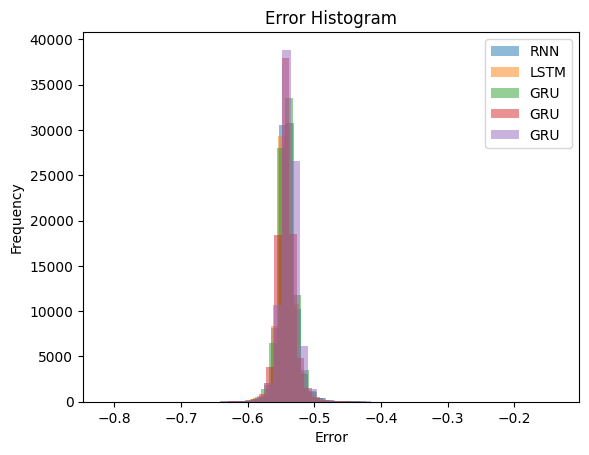

In [57]:
plt.hist(errors_rnn, bins=50, alpha=0.5, label='RNN')
plt.hist(errors_lstm, bins=50, alpha=0.5, label='LSTM')
plt.hist(errors_gru, bins=50, alpha=0.5, label='GRU')
plt.hist(errors_bbrnn, bins=50, alpha=0.5, label='GRU')
plt.hist(errors_bsrnn, bins=50, alpha=0.5, label='GRU')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Error Histogram')
plt.show()


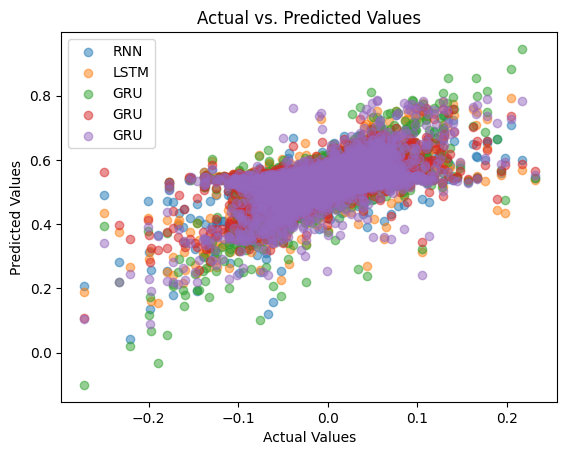

In [60]:
plt.scatter(y_test, predictions_rnn, alpha=0.5, label='RNN')
plt.scatter(y_test, predictions_lstm, alpha=0.5, label='LSTM')
plt.scatter(y_test, predictions_gru, alpha=0.5, label='GRU')
plt.scatter(y_test, predictions_bidirectional_rnn, alpha=0.5, label='GRU')
plt.scatter(y_test, predictions_stacked_rnn, alpha=0.5, label='GRU')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Actual vs. Predicted Values')
plt.show()


In [69]:
import optuna

def objective(trial):
    neurons = trial.suggest_categorical('neurons', [20, 50, 100])
    
    model = Sequential([
        SimpleRNN(neurons, return_sequences=True, input_shape=input_shape),
        SimpleRNN(neurons, return_sequences=True),
        SimpleRNN(neurons),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    loss = model.evaluate(X_val, y_val, verbose=0)
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print(study.best_trial)


[I 2023-11-24 04:06:15,942] A new study created in memory with name: no-name-0f4c56f0-007a-4a02-b201-6135357619aa
[I 2023-11-24 04:08:13,206] Trial 0 finished with value: 0.0007059252238832414 and parameters: {'neurons': 20}. Best is trial 0 with value: 0.0007059252238832414.
[I 2023-11-24 04:10:42,129] Trial 1 finished with value: 0.000754358887206763 and parameters: {'neurons': 100}. Best is trial 0 with value: 0.0007059252238832414.
[I 2023-11-24 04:12:53,449] Trial 2 finished with value: 0.0007441297057084739 and parameters: {'neurons': 50}. Best is trial 0 with value: 0.0007059252238832414.
[I 2023-11-24 04:14:53,964] Trial 3 finished with value: 0.0008114337688311934 and parameters: {'neurons': 50}. Best is trial 0 with value: 0.0007059252238832414.
[I 2023-11-24 04:17:13,716] Trial 4 finished with value: 0.0008235485875047743 and parameters: {'neurons': 100}. Best is trial 0 with value: 0.0007059252238832414.
[I 2023-11-24 04:19:33,528] Trial 5 finished with value: 0.00111397751

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.0007059252238832414], datetime_start=datetime.datetime(2023, 11, 24, 4, 6, 15, 943965), datetime_complete=datetime.datetime(2023, 11, 24, 4, 8, 13, 206896), params={'neurons': 20}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'neurons': CategoricalDistribution(choices=(20, 50, 100))}, trial_id=0, value=None)


Epoch 1/50
1751/1751 [==============================] - 12s 6ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 2/50
1751/1751 [==============================] - 11s 6ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3/50
1751/1751 [==============================] - 10s 6ms/step - loss: 0.0011 - val_loss: 9.7763e-04
Epoch 4/50
1751/1751 [==============================] - 10s 6ms/step - loss: 9.6414e-04 - val_loss: 8.4786e-04
Epoch 5/50
1751/1751 [==============================] - 10s 6ms/step - loss: 8.7503e-04 - val_loss: 7.7614e-04
Epoch 6/50
1751/1751 [==============================] - 11s 6ms/step - loss: 8.3279e-04 - val_loss: 8.9383e-04
Epoch 7/50
1751/1751 [==============================] - 11s 6ms/step - loss: 8.1495e-04 - val_loss: 8.6238e-04
Epoch 8/50
1751/1751 [==============================] - 11s 6ms/step - loss: 8.0024e-04 - val_loss: 8.9691e-04
Epoch 9/50
1751/1751 [==============================] - 11s 6ms/step - loss: 7.8657e-04 - val_loss: 8.9119e-04
Epoch 10/50
1751/1751

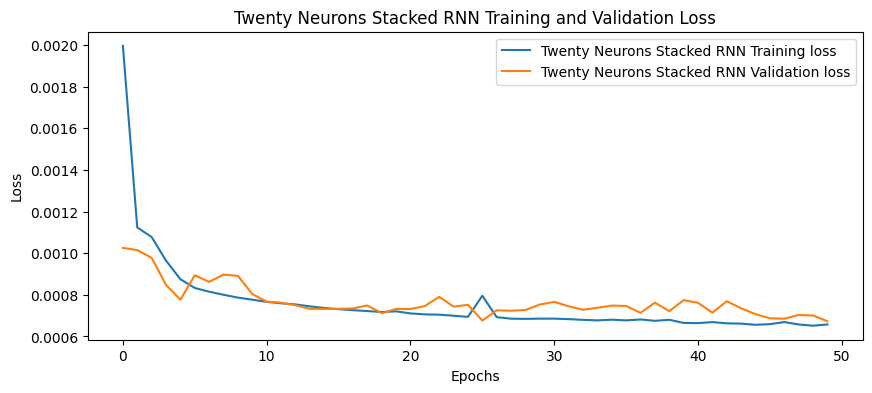

2736/2736 [==============================] - 6s 2ms/step
Twenty Neurons Stacked RNN - MSE: 0.2915, MAE: 0.5397, RMSE: 0.5399


In [71]:
def twentyn_stacked_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(20, return_sequences=True, input_shape=input_shape),
        SimpleRNN(20, return_sequences=True),
        SimpleRNN(20),
        Dense(25),
        Dense(1)
    ])
    return model

tnsrnn_model = compile_model(twentyn_stacked_rnn_model(input_shape))

start_time = time.time()
history_twentyn_stacked_rnn = tnsrnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, shuffle=False)
end_time = time.time()
twentyn_stacked_rnn_training_time = end_time - start_time
print("Twenty Neurons Stacked RNN Training Time: {:.2f} seconds".format(twentyn_stacked_rnn_training_time))

plt.figure(figsize=(10, 4))
plt.plot(history_twentyn_stacked_rnn.history['loss'], label='Twenty Neurons Stacked RNN Training loss')
plt.plot(history_twentyn_stacked_rnn.history['val_loss'], label='Twenty Neurons Stacked RNN Validation loss')
plt.title('Twenty Neurons Stacked RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

predictions_twentyn_stacked_rnn = tnsrnn_model.predict(X_test)

metrics_twentyn_stacked_rnn = calculate_metrics(y_test, predictions_twentyn_stacked_rnn)

print_metrics("Twenty Neurons Stacked RNN", metrics_twentyn_stacked_rnn)


In [84]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import numpy as np

def create_model(trial):
    # Hyperparameter space
    neurons = trial.suggest_categorical('neurons', [10, 20, 30, 40])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    # Model construction
    model = Sequential([
        SimpleRNN(neurons, return_sequences=True, input_shape=input_shape, dropout=dropout_rate),
        SimpleRNN(neurons, return_sequences=True, dropout=dropout_rate),
        SimpleRNN(neurons, dropout=dropout_rate),
        Dense(25),
        Dense(1)
    ])

    # Compile model
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

def objective(trial):
    model = create_model(trial)
    
    model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=0)
    
    loss = model.evaluate(X_val, y_val, verbose=0)
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print('Best trial:', study.best_trial.params)


[I 2023-11-24 09:56:10,881] A new study created in memory with name: no-name-001fb32c-e130-425b-a680-bbd0e9f1a5f6
[I 2023-11-24 09:58:19,357] Trial 0 finished with value: 0.001207015011459589 and parameters: {'neurons': 30, 'dropout_rate': 0.4245224787359685, 'optimizer': 'rmsprop', 'learning_rate': 0.0003694811994129284}. Best is trial 0 with value: 0.001207015011459589.
[I 2023-11-24 10:00:19,105] Trial 1 finished with value: 0.000968735315836966 and parameters: {'neurons': 20, 'dropout_rate': 0.15048177962993964, 'optimizer': 'rmsprop', 'learning_rate': 1.5038264273355343e-05}. Best is trial 1 with value: 0.000968735315836966.
[I 2023-11-24 10:02:28,441] Trial 2 finished with value: 0.0009308097651228309 and parameters: {'neurons': 40, 'dropout_rate': 0.15163627801004786, 'optimizer': 'adam', 'learning_rate': 6.213413240509233e-05}. Best is trial 2 with value: 0.0009308097651228309.
[I 2023-11-24 10:04:21,770] Trial 3 finished with value: 0.0009482064633630216 and parameters: {'neur

Best trial: {'neurons': 10, 'dropout_rate': 0.0021752371274864103, 'optimizer': 'adam', 'learning_rate': 0.00656048885215407}


Epoch 1/50
1751/1751 [==============================] - 14s 7ms/step - loss: 0.0015 - val_loss: 9.5159e-04
Epoch 2/50
1751/1751 [==============================] - 13s 7ms/step - loss: 0.0011 - val_loss: 9.5434e-04
Epoch 3/50
1751/1751 [==============================] - 13s 7ms/step - loss: 9.6761e-04 - val_loss: 8.1977e-04
Epoch 4/50
1751/1751 [==============================] - 13s 8ms/step - loss: 9.2686e-04 - val_loss: 8.1022e-04
Epoch 5/50
1751/1751 [==============================] - 14s 8ms/step - loss: 8.6771e-04 - val_loss: 8.8493e-04
Epoch 6/50
1751/1751 [==============================] - 12s 7ms/step - loss: 8.4133e-04 - val_loss: 8.9106e-04
Epoch 7/50
1751/1751 [==============================] - 11s 7ms/step - loss: 8.1919e-04 - val_loss: 8.5051e-04
Epoch 8/50
1751/1751 [==============================] - 11s 7ms/step - loss: 7.9859e-04 - val_loss: 8.2528e-04
Epoch 9/50
1751/1751 [==============================] - 11s 7ms/step - loss: 7.9991e-04 - val_loss: 7.2574e-04
Epoch 10/

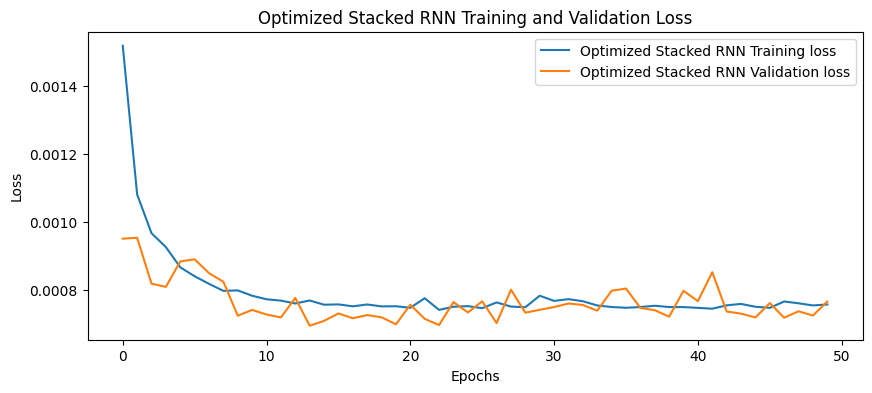

2736/2736 [==============================] - 6s 2ms/step
Optimized Stacked RNN - MSE: 0.2890, MAE: 0.5375, RMSE: 0.5376


In [85]:
from tensorflow.keras.layers import Dropout

def optimized_stacked_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(10, return_sequences=True, input_shape=input_shape),
        Dropout(0.0021752371274864103),
        SimpleRNN(10, return_sequences=True),
        Dropout(0.0021752371274864103),
        SimpleRNN(10),
        Dense(25),
        Dense(1)
    ])
    return model

opt_tnsrnn_model = compile_model(optimized_stacked_rnn_model(input_shape))

# Compile model with the optimized learning rate
opt_tnsrnn_model.compile(optimizer=Adam(learning_rate=0.00656048885215407), 
                         loss='mean_squared_error')

start_time = time.time()
history_opt_tnsrnn = opt_tnsrnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, shuffle=False)
end_time = time.time()
opt_tnsrnn_training_time = end_time - start_time
print("Optimized Stacked RNN Training Time: {:.2f} seconds".format(opt_tnsrnn_training_time))

plt.figure(figsize=(10, 4))
plt.plot(history_opt_tnsrnn.history['loss'], label='Optimized Stacked RNN Training loss')
plt.plot(history_opt_tnsrnn.history['val_loss'], label='Optimized Stacked RNN Validation loss')
plt.title('Optimized Stacked RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

predictions_opt_tnsrnn = opt_tnsrnn_model.predict(X_test)
metrics_opt_tnsrnn = calculate_metrics(y_test, predictions_opt_tnsrnn)
print_metrics("Optimized Stacked RNN", metrics_opt_tnsrnn)
